In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import (
    rnn_regression_model, 
    compile_regression_model,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.load import load_rna_structure_dataset

In [2]:
np.random.seed(444)

sns.set(palette='colorblind', font_scale=1.3)

## Model

In [3]:
alphabet = ['.', '(', ')']
alphabet_size = len(alphabet)
    
model = rnn_regression_model(alphabet_size=alphabet_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 3)      0           sequence[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          41600       masking[0][0]                    
__________________________________________________________________________________________________
logits (Dense)                  (None, 100)          10100       lstm[0][0]                       
______________________________________________________________________________________________

In [4]:
compile_regression_model(model, learning_rate=1e-4)

In [5]:
model_path = 'saved_models/mrna_learn.h5'
model.load_weights(model_path)

## Data

In [6]:
%%time
metadata = pd.read_csv('data/tab/mrna.tab', delimiter='\t')
metadata['category'] = metadata['temp.cat']

sequences = load_rna_structure_dataset(metadata, 'data/seq/')

CPU times: user 558 ms, sys: 269 ms, total: 827 ms
Wall time: 827 ms


In [7]:
metadata.head()

,sp,taxid,temp.cat,rna.type,temp,length,gc,paired,asa,sd.asa,maxmin.asa,mfe,mfe1,mfe2,mfe3,category
0,Achromobacter denitrificans,32002,mRNA eno,mesophile,30,1281,0.711944,0.685402,159.123952,16.743722,112.4710,-687.0,-116.113844,-257.076746,-44.467685,mRNA eno
1,Acidithiobacillus ferrooxidans,920,mRNA eno,mesophile,31,1281,0.578454,0.661983,171.630226,11.805094,98.4460,-515.9,-84.663969,-85.976746,-13.017809,mRNA eno
2,Actinobacillus pleuropneumoniae,715,mRNA eno,mesophile,37,1311,0.421053,0.607170,141.066765,18.037808,127.2285,-369.0,-102.429906,71.401738,-20.539147,mRNA eno
3,Actinobacillus suis,716,mRNA eno,mesophile,37,1311,0.397407,0.639207,143.607326,18.291201,132.1183,-369.4,-127.567266,71.001738,-45.676507,mRNA eno
4,Aequorivita sublithincola,101385,mRNA eno,psychrophile,4,1287,0.397824,0.581197,177.095760,11.562361,90.4570,-323.9,-81.630144,108.118951,-7.935065,mRNA eno


In [8]:
%%time
x = sequence_embedding(sequences, alphabet)
y = metadata['temp'].values.astype(np.float32)

CPU times: user 12 s, sys: 707 ms, total: 12.7 s
Wall time: 12.7 s


In [9]:
n_seq = len(sequences)
test_idx = np.random.choice(range(n_seq), size=int(0.2 * n_seq), replace=False)
test_idx_set = set(test_idx.tolist())
train_idx = np.array([idx for idx in range(n_seq) if idx not in test_idx_set])

mean, std = np.mean(y), np.std(y)

x_test, y_test = x[test_idx], y[test_idx]
x_train, y_train = x[train_idx], y[train_idx]

y_test_norm = normalize(y_test, mean, std)
y_train_norm = normalize(y_train, mean, std)

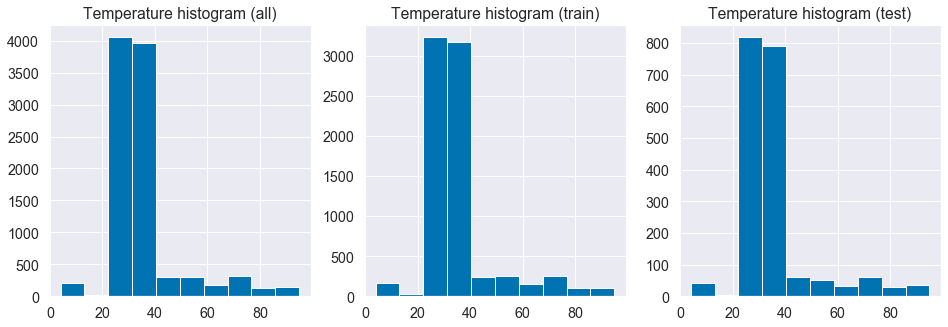

In [10]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))
axes = axes.flatten()
metadata['temp'].hist(ax=axes[0]);
axes[0].set_title('Temperature histogram (all)')
metadata['temp'].iloc[train_idx].hist(ax=axes[1]);
axes[1].set_title('Temperature histogram (train)')
metadata['temp'].iloc[test_idx].hist(ax=axes[2]);
axes[2].set_title('Temperature histogram (test)');

## Evaluation

In [11]:
%%time
model.evaluate(x_test, y_test_norm, verbose=0)

CPU times: user 1min 9s, sys: 16.3 s, total: 1min 26s
Wall time: 30.8 s


1.4434865088571878

In [13]:
%%time
y_hat = model(x_test)
y_hat_mean = y_hat.mean()
y_mean = denormalize(y_hat_mean, mean, std)
y_std = denormalize(y_hat.stddev(), mean, std)

CPU times: user 1min 22s, sys: 1min 52s, total: 3min 15s
Wall time: 42.7 s


In [23]:
def plot_true_vs_prediction_scatter(metadata, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    for i, tpl in enumerate(metadata.itertuples()):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    x_straight = range(0, 100)
    ax.plot(x_straight, x_straight, '--', color=palette[1], alpha=0.5)
    
    ax.set_xlabel('Temperature °C (true)')
    ax.set_ylabel('Temperature °C (prediction)')

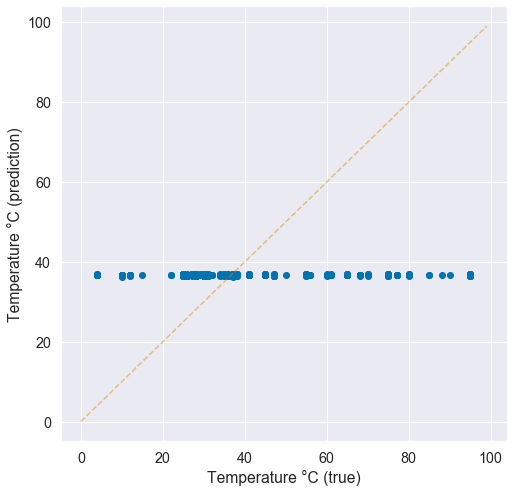

In [24]:
plot_true_vs_prediction_scatter(metadata.iloc[test_idx], y_test, y_mean)